# Music Data File list 

In [2]:
import os
for dirname, _, filenames in os.walk('../music_classify/Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

../music_classify/Data/features_30_sec.csv
../music_classify/Data/features_3_sec.csv
../music_classify/Data/images_original/country/country00031.png
../music_classify/Data/images_original/country/country00038.png
../music_classify/Data/images_original/country/country00010.png
../music_classify/Data/images_original/country/country00034.png
../music_classify/Data/images_original/country/country00013.png
../music_classify/Data/images_original/country/country00001.png
../music_classify/Data/images_original/country/country00091.png
../music_classify/Data/images_original/country/country00000.png
../music_classify/Data/images_original/country/country00046.png
../music_classify/Data/images_original/country/country00061.png
../music_classify/Data/images_original/country/country00021.png
../music_classify/Data/images_original/country/country00087.png
../music_classify/Data/images_original/country/country00080.png
../music_classify/Data/images_original/country/country00072.png
../music_classify/D

# Data analysis

In [6]:
%matplotlib inline
import librosa, IPython
import librosa.display as lplt
audio_fp = '../music_classify/Data/genres_original/jazz/jazz.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [7]:
%matplotlib inline
import librosa, IPython
import librosa.display as lplt
IPython.display.Audio(audio_data, rate=sr)

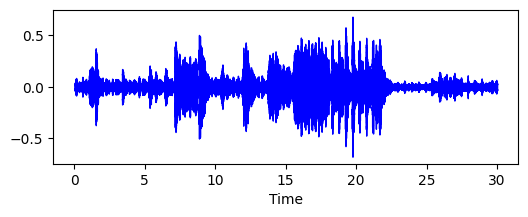

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 2))
librosa.display.waveshow(audio_data, color = "BLUE")
plt.show()

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os

import librosa
import librosa.display

import torch
from torch import nn
from torchvision import models, transforms, datasets
from time import time
from tqdm import tqdm

In [11]:
seed = 30
np.random.seed(seed)

path = "../music_classify/Data"

path_audio_files = path + "/genres_original/"

path_imgs = "./mel_spectrogram_imgs/"

batch_size = 16

hop_length = 1024

n_fft = 2048

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}

cuda


# Transform WAV file to Mel Spectorgrams

In [ ]:
print("Transforming the Audio Files into Mel Spectrograms:")

mel_spectogram_data = {}
for genre in genre_dict.keys():
    print("\t",genre)
    
    mel_spectogram_data[genre] = []

    for name in glob.glob(path_audio_files + genre + "/*"):
        
        if(name != "../music_classify/Data/genres_original/jazz/jazz.00054.wav"):
        
            data,sampling_rate = librosa.load(name)

            mel_spec = librosa.feature.melspectrogram(y = data.ravel(), sr=sampling_rate,hop_length = hop_length)
            mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

            mel_spectogram_data[genre].append(mel_spec_db)
            

print("Saving the Mel Spectrogram Images:")
            
os.mkdir(path_imgs)
for genre in genre_dict.keys():
    print("\t",genre)
    try:
        os.mkdir(path_imgs + genre)
    except:
        pass
    
    for i in range(len(mel_spectogram_data[genre])):

        fig, ax = plt.subplots(1, figsize=(12,8))

        img = librosa.display.specshow(mel_spectogram_data[genre][i], sr = sampling_rate, hop_length = hop_length,cmap = 'cool',ax=ax)

        fig.savefig(path_imgs + genre + "/" + genre + "_" + str(i) + ".png")
        
        plt.close()

In [12]:
# gc and empty cuda cache
import gc
gc.collect()
torch.cuda.empty_cache()


In [39]:
%%time

# Define Tranforms
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
])

# Load the data
train_dataset = datasets.ImageFolder(path_imgs, transform = train_transforms)
val_dataset = datasets.ImageFolder(path_imgs, transform = test_transforms)
test_dataset = datasets.ImageFolder(path_imgs, transform = test_transforms)

torch.manual_seed(1)
num_train_samples = len(train_dataset)

# Permute dataset 
indices = torch.randperm(num_train_samples)

# Split the dataset into Train and Validation
train_testval_split = 0.2
train_split = int(num_train_samples * train_testval_split)
val_split = int(train_split * 0.5)

train_subset = torch.utils.data.Subset(train_dataset, indices[train_split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[val_split:train_split])
test_subset = torch.utils.data.Subset(test_dataset, indices[:val_split])

print(f"Length of Train:{len(train_subset)}; Length of Val:{len(val_subset)}; Length of Test:{len(test_subset)}")



# Make DataLoaders 
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=8
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

# Classes
classes = train_dataloader.dataset.dataset.classes

Length of Train:800; Length of Val:100; Length of Test:99
CPU times: user 9.94 ms, sys: 2.28 ms, total: 12.2 ms
Wall time: 11.7 ms


In [16]:
def mean_std(loader):
    images, lebels = next(iter(loader))
    # shape of images = [b,c,w,h]
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

mean, std = mean_std(train_dataloader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([-0.0125,  2.0498,  2.6217]) tensor([1.9323, 0.6755, 0.1495])


# Training Using Pretrained "Efficientnet-B0"

In [17]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(classes))

Loaded pretrained weights for efficientnet-b0


In [18]:
for params in model.parameters():
        params.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#optimizer = torch.optim.SGD(model.parameters(),lr = 0.005,momentum=0.9,weight_decay=1e-4)
lmbda = lambda epoch: 0.98739
exp_lr_scheduler =torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.0005,momentum=0.7,weight_decay=1e-3)

In [19]:
from copy import deepcopy
def train(model, criterion, optimizer, train_dataloader,test_dataloader,print_every,num_epoch):
    best_acc_model = None 
    steps = 0
    train_losses, val_losses = [], []
    best_acc = 0
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
    model.to(device)
    print(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()
                        
                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()
                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        if correct_val / total_val * 100 > best_acc:
          best_acc = correct_val / total_val * 100
          best_acc_model = deepcopy(model.state_dict())
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

In [ ]:
print_every = 25
num_epoch = 100

model, train_losses, val_losses = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    print_every=print_every,
    num_epoch=num_epoch
)


plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [33]:
y_test = []
y_pred = []
for img, label in test_subset:
    img = torch.Tensor(img)
    img = img.to(device)
    model.eval()
    prediction = model(img[None])
    
    final_pred = classes[torch.max(prediction, dim=1)[1]]
    
    y_test.append(label)
    y_pred.append(genre_dict[final_pred])
    

In [34]:
print("Accuracy:",(100*(np.array(y_test) == np.array(y_pred)).sum()/len(y_test)))

Accuracy: 80.40201005025126


In [35]:
from torcheval.metrics.functional import multiclass_f1_score
F1_Score=multiclass_f1_score(torch.tensor(y_test),torch.tensor(y_pred),num_classes=10)
score=np.float16(F1_Score)
print(f'F1_Score:',score)

F1_Score: 0.804


In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)

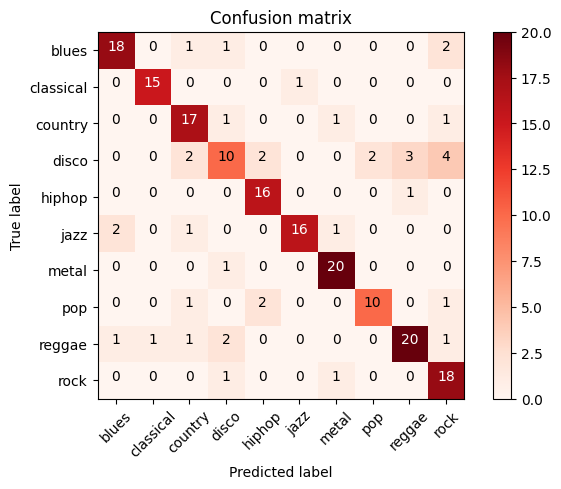

In [37]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()